In [1]:
# import the packages
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.model_selection import KFold, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score

# Predicting attitudes towards racist college professors

In [2]:
gss_train = pd.read_csv("data/gss_train.csv")

In [3]:
gss_train.columns

Index(['age', 'attend', 'authoritarianism', 'black', 'born', 'childs',
       'colath', 'colrac', 'colcom', 'colmil', 'colhomo', 'colmslm',
       'con_govt', 'egalit_scale', 'evangelical', 'grass', 'happy',
       'hispanic_2', 'homosex', 'income06', 'mode', 'owngun', 'polviews',
       'pornlaw2', 'pray', 'pres08', 'reborn_r', 'science_quiz', 'sex', 'sibs',
       'social_connect', 'south', 'teensex', 'tolerance', 'tvhours',
       'vetyears', 'wordsum', 'degree_Bachelor.deg', 'degree_other',
       'marital_Divorced', 'marital_Never.married', 'marital_other',
       'news_FEW.TIMES.A.WEEK', 'news_LESS.THAN.ONCE.WK', 'news_NEVER',
       'news_other', 'partyid_3_Ind', 'partyid_3_Rep', 'relig_CATHOLIC',
       'relig_NONE', 'relig_other', 'social_cons3_Mod', 'social_cons3_Conserv',
       'spend3_Mod', 'spend3_Liberal', 'zodiac_other'],
      dtype='object')

## Train a series of models

### Use 10-fold cross-validation to partition the training set into training and validation sets.

In [4]:
kfold = KFold(10, True, random_state = 30100)

### Fit the following statistical models using 10-fold cross-validation:
* **Logistic regression**
* **Linear discriminant analysis**
* **Quadratic discriminant analysis**
* **Naive Bayes**
* **K-nearest neighbors**

**Use all available predictors for each model.
I am not specifying hyperparameter settings for any of the modeling strategies. I leave it to you to determine the optimal settings. However, you need to briefly justify how you selected your hyperparameter settings. Don’t just arbitrarily select values, do some tuning.**

After reading the documentation of the GSS survey, I find almost all of the variables can be potentially eligible to predict the outcome '**colrac**'. Generally I can categorize them into the following five domains:
* Religion related: attend, evangelical, pray, relig_CATHOLIC ...
* Ideology and political related: authoritarianism, grass, owngun, colath ...
* Democratic features: age, black, born, childs, income...
* Overall wellbeing: happy ...
* Education and intelligence: science_quiz, wordsum, degrees_Bachelor.deg ...

Different religions, education, level of psychological wellbeing can more or less influence one's view towards different races and their eligibility to do specific types of jobs. Ideology is very reflective to one's inner standpoints. Besides, demographic features are the most common factors that we put into statistical models. Therefore, I decide to put all these variables in, expect the 'zodiac_other' variable which I don't feel substantially related. I will try the following models: logistic, LDA, QDA, Naive Bayes, and KNearest Neighbors with k from 1 to 10.

In [5]:
x = gss_train.iloc[:,(gss_train.columns!='colrac') & (gss_train.columns!='zodiac_other')]
y = gss_train['colrac']

#### Logistic

In [6]:
logit = LogisticRegression()

#### Linear Discrimination Analysis

In [7]:
lda = LinearDiscriminantAnalysis(solver="svd", store_covariance=True)

#### Quadratic Discrimination Analysis

In [8]:
qda = QuadraticDiscriminantAnalysis(store_covariance=True)

#### Naive Bayes

In [9]:
nb = GaussianNB()

#### KNearest Neighbors

In [10]:
knn = []
for i in range(1, 11):
    knn.append(KNeighborsClassifier(i))

## Evaluate their performance

### Evaluate each model’s performance using the validation set. Select the best model based on the validation set performance and whatever metrics you feel are important (e.g. error rate, proportional reduction in error, ROC curve, area under the curve).

#### Error Rate

In [11]:
model_names = ['Logistic', 'LDA', 'QDA', 'Naive Bayes'] + ['KNN_'+str(i) for i in range(1,11)]
models = [logit] + [lda] + [qda] + [nb] + knn

error_rates = []
for m in models:
    error_rate = 1 - cross_val_score(m, x, y, scoring = 'accuracy', cv = kfold).mean()
    error_rates.append(error_rate)

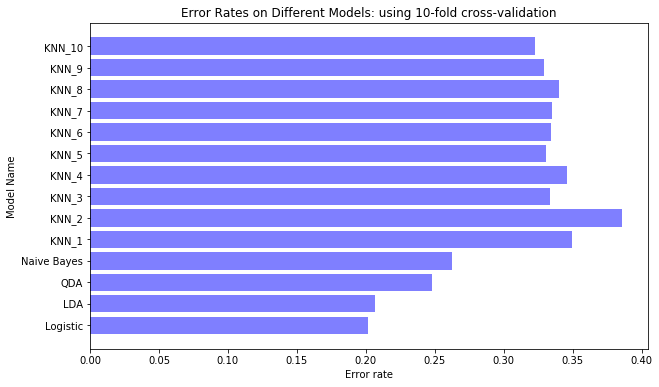

In [12]:
fig, ax = plt.subplots()
fig.set_size_inches(10, 6)
ax.barh(range(len(model_names)), error_rates, color = 'b', alpha = 0.5)
ax.set_yticks(range(len(model_names)))
ax.set_yticklabels(model_names)
ax.set_xlabel('Error rate'); ax.set_ylabel('Model Name')
ax.set_title('Error Rates on Different Models: using 10-fold cross-validation')
plt.show()

#### Area Under the Curve

In [13]:
aucs = []
for m in models:
    auc = cross_val_score(m, x, y, scoring = 'roc_auc', cv = kfold).mean()
    aucs.append(auc)

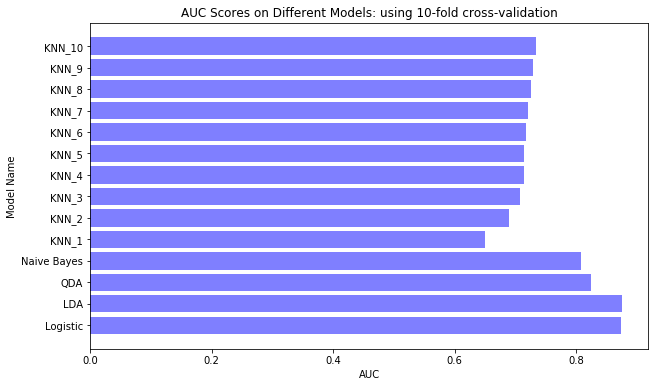

In [14]:
fig, ax = plt.subplots()
fig.set_size_inches(10, 6)
ax.barh(range(len(model_names)), aucs, color = 'b', alpha = 0.5)
ax.set_yticks(range(len(model_names)))
ax.set_yticklabels(model_names)
ax.set_xlabel('AUC'); ax.set_ylabel('Model Name')
ax.set_title('AUC Scores on Different Models: using 10-fold cross-validation')
plt.show()

After trying all these models with my variable and parameter settings, I found the logistic regreession model turn out to be the best-performed one, with the **lowest error rate(20.12%)** and the **almost highest AUC score(0.87)**.

### Once you select the best model, calculate your final estimate of the test error rate using the test set (gss_test.csv). To do this, take your best model and re-fit it using the entire training set (i.e. no cross-validation). Then calculate your performance metrics using the original test set.

In [15]:
gss_test = pd.read_csv("data/gss_test.csv")

x_test = gss_test.iloc[:,(gss_test.columns!='colrac') & (gss_test.columns!='zodiac_other')]
y_test = gss_test['colrac']

In [16]:
logit_test = LogisticRegression().fit(x, y)

In [17]:
pred = logit_test.predict(x_test)
error = 1*(pred!=y_test).sum()/len(y_test)
pred_prob = logit_test.predict_proba(x_test)[:,1]
auc = roc_auc_score(y_test, pred_prob)
print('error rate: {:.2%}'.format(error))
print('AUC score: {:.2f}'.format(auc))

error rate: 21.70%
AUC score: 0.86


## Interpret and explain the model

### Global explanations: Using the naive Bayes model, explain how the model works globally using the following techniques

#### Feature importance

In [18]:
nb = GaussianNB().fit(x, y)

In [19]:
from skater.model import InMemoryModel
from skater.core.explanations import Interpretation

model = InMemoryModel(nb.predict_proba, examples = x)
interpreter = Interpretation(training_data=x)
featImp = interpreter.feature_importance.feature_importance(model,ascending=True)

2019-02-11 12:09:37,643 - skater.core.explanations - WARNING - Progress bars slow down runs by 10-20%. For slightly 
faster runs, do progress_bar=False


[54/54] features ████████████████████ Time elapsed: 10 seconds

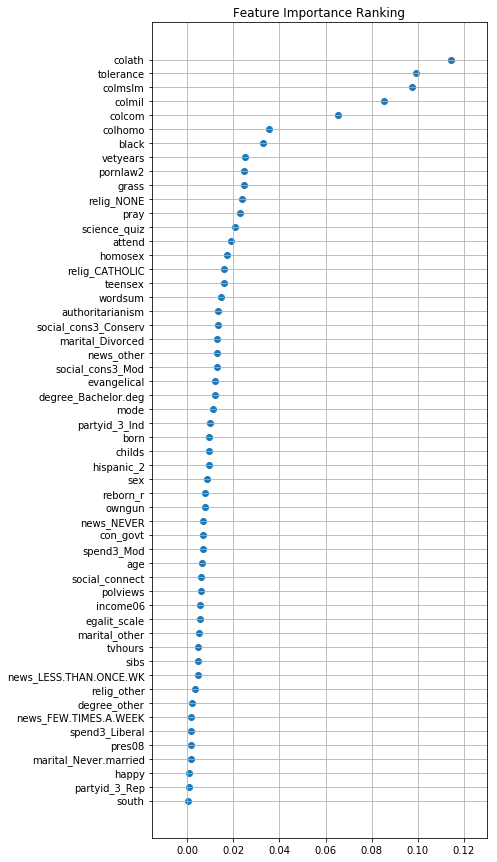

In [20]:
plt.figure(figsize=(6,15))
plt.scatter(featImp.values, np.arange(len(featImp)))
plt.yticks(np.arange(len(featImp)), featImp.index)
plt.grid()
plt.title("Feature Importance Ranking")
plt.show()

The five most important features, according to these feature importance scores, are 'colath', 'colmslm', 'tolerance', 'colmil', 'colcom'.

#### Feature interactions

Sorry I didn't find a well built package aimed at the analysis.

#### Partial dependence plots (PDPs) and individual conditional expectation (ICE) plots: Generate plots for the five most important variables as determined by the feature importance scores

In [21]:
from pycebox.ice import ice, ice_plot

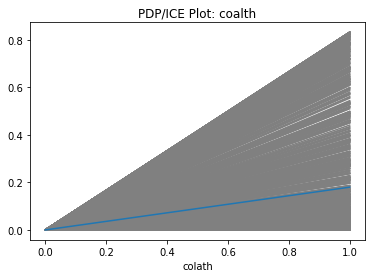

In [22]:
df = ice(x, 'colath', lambda x: nb.predict_proba(x)[:,1], num_grid_points=100)
ice_plot(df,c = 'grey', plot_pdp=True, centered=True)
plt.xlabel('colath')
plt.title("PDP/ICE Plot: coalth")
plt.show()

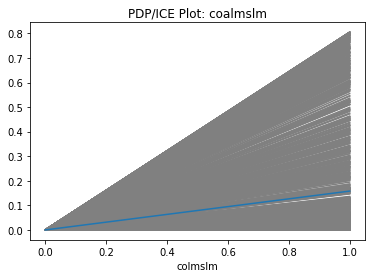

In [23]:
df = ice(x, 'colmslm', lambda x: nb.predict_proba(x)[:,1], num_grid_points=100)
ice_plot(df,c = 'grey', plot_pdp=True, centered=True)
plt.xlabel('colmslm')
plt.title("PDP/ICE Plot: coalmslm")
plt.show()

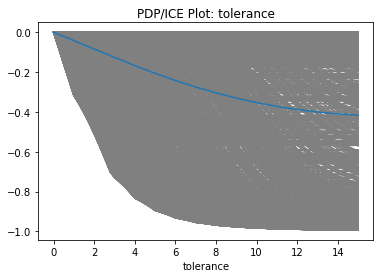

In [24]:
df = ice(x, 'tolerance', lambda x: nb.predict_proba(x)[:,1], num_grid_points=100)
ice_plot(df,c = 'grey', plot_pdp=True, centered=True)
plt.xlabel('tolerance')
plt.title("PDP/ICE Plot: tolerance")
plt.show()

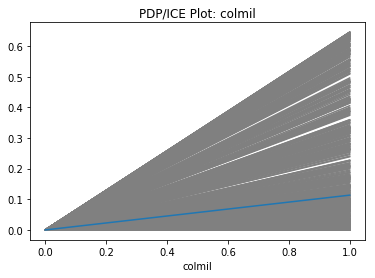

In [25]:
df = ice(x, 'colmil', lambda x: nb.predict_proba(x)[:,1], num_grid_points=100)
ice_plot(df,c = 'grey', plot_pdp=True, centered=True)
plt.xlabel('colmil')
plt.title("PDP/ICE Plot: colmil")
plt.show()

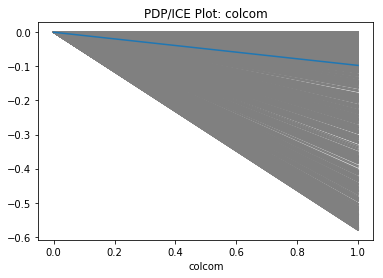

In [26]:
df = ice(x, 'colcom', lambda x: nb.predict_proba(x)[:,1], num_grid_points=100)
ice_plot(df,c = 'grey', plot_pdp=True, centered=True)
plt.xlabel('colcom')
plt.title("PDP/ICE Plot: colcom")
plt.show()

Only 'tolerance' and 'colcom' seem to have negative average effects.

#### Global surrogate

In [27]:
# fit a new linear regression model using the surrogate variables and the predictions from the Naive Bayes model
x_surr = gss_train[['colath', 'colmslm', 'tolerance', 'colmil', 'colcom']].values
y_pred = nb.predict_proba(x)[:,1]

model_surro = LinearRegression().fit(x_surr, y_pred)

In [28]:
for name,value in zip(['colath', 'colmslm', 'tolerance', 'colmil', 'colcom'],model_surro.coef_):
    print("The estimated coefficient of variable {} is {}".format(name, value))

The estimated coefficient of variable colath is 0.23153805391482019
The estimated coefficient of variable colmslm is 0.27534031123763414
The estimated coefficient of variable tolerance is -0.03802419502612376
The estimated coefficient of variable colmil is 0.17007031824788071
The estimated coefficient of variable colcom is -0.18396052439958818


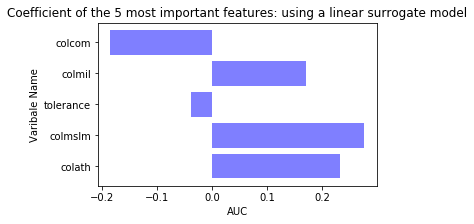

In [29]:
fig, ax = plt.subplots()
fig.set_size_inches(5, 3)
ax.barh(range(len(model_surro.coef_)), model_surro.coef_, color = 'b', alpha = 0.5)
ax.set_yticks(range(len(model_surro.coef_)))
ax.set_yticklabels(['colath', 'colmslm', 'tolerance', 'colmil', 'colcom'])
ax.set_xlabel('AUC'); ax.set_ylabel('Varibale Name')
ax.set_title('Coefficient of the 5 most important features: using a linear surrogate model')
plt.show()

The results from this linear surrogate model coincide with the previous PDP/ICE interpretations.

### Local interpretation

Using your naive Bayes model, explain how the model works locally for the five held-out observations in gss_local.csv using the lime procedure.  

In [30]:
gss_local = pd.read_csv('data\gss_local.csv')

In [31]:
gss_local.head()

,age,attend,authoritarianism,black,born,childs,colath,colrac,colcom,colmil,...,partyid_3_Ind,partyid_3_Rep,relig_CATHOLIC,relig_NONE,relig_other,social_cons3_Mod,social_cons3_Conserv,spend3_Mod,spend3_Liberal,zodiac_other
0,60,5,2,0,0,3,1,1,1,0,...,1,0,0,0,0,1,0,0,0,1
1,62,0,4,0,0,1,1,1,0,0,...,0,1,1,0,0,0,1,0,0,1
2,79,8,3,1,1,2,0,1,1,1,...,0,0,0,0,0,1,0,0,0,1
3,70,1,1,0,0,3,0,0,1,0,...,0,0,1,0,0,0,0,0,0,0
4,31,0,4,0,0,0,0,0,1,0,...,1,0,0,0,1,0,0,0,1,1


#### First, generate the local surrogate model using the default hyperparameters for lime and interpret the surrogate model for each observation.

In [32]:
import lime
import lime.lime_tabular

x_full = gss_train.iloc[:,(gss_train.columns!='colrac')]; y_full = gss_train['colrac']

explainer_full = lime.lime_tabular.LimeTabularExplainer(x_full.values, feature_names=np.array(x_full.columns), 
                                                   class_names=['not allowed', ': allowed'])

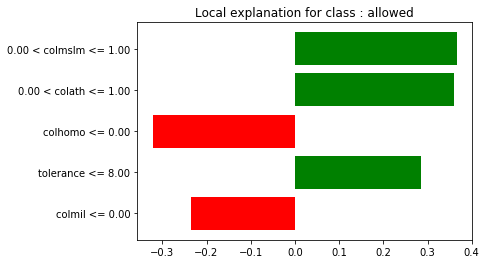

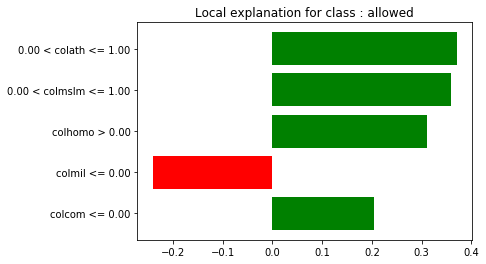

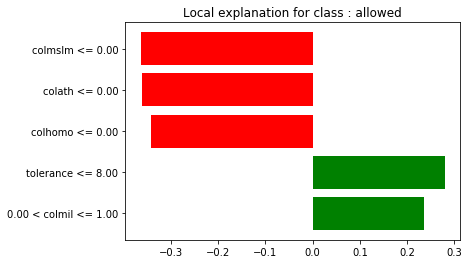

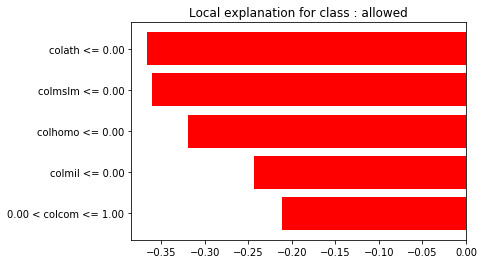

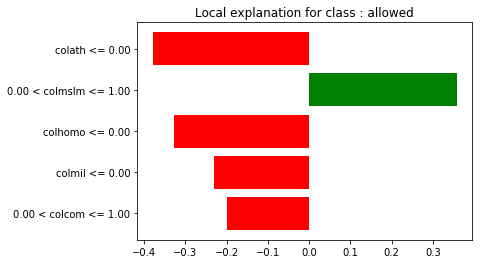

In [33]:
nb_full = GaussianNB().fit(x_full, y_full)
x_local = gss_local.iloc[:,(gss_local.columns!='colrac')]

for i in range(5):
    exp = explainer_full.explain_instance(x_local.iloc[i].values, nb_full.predict_proba, num_features=5)
    exp.as_pyplot_figure()

#### Second, generate the local surrogate model by tuning the hyperparameters for lime and interpret the surrogate model for each observation. How does your interpretation change, if at all?

In [34]:
explainer_tuned = lime.lime_tabular.LimeTabularExplainer(x.values, feature_names=np.array(x.columns), 
                                                   class_names=['not allowed', ': allowed'])

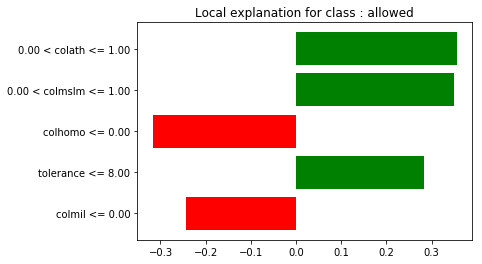

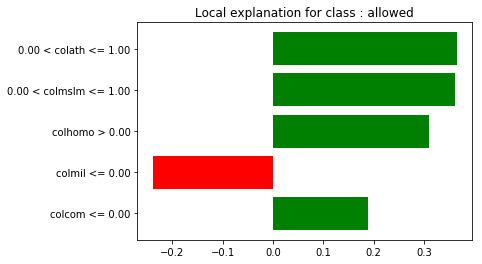

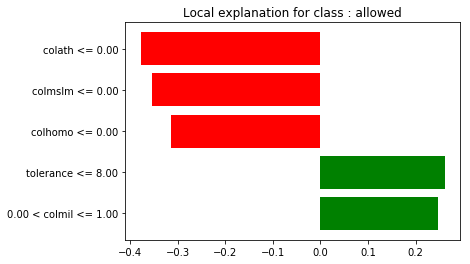

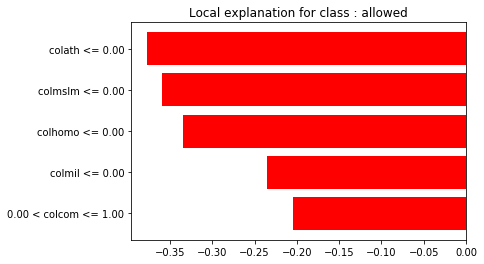

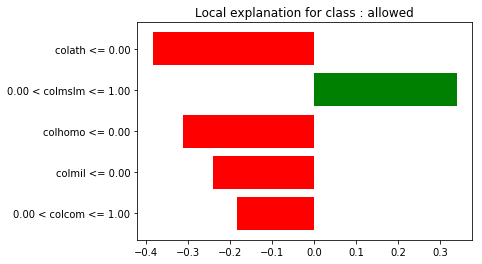

In [35]:
x_local = gss_local.iloc[:,(gss_local.columns!='colrac')&(gss_local.columns!='zodiac_other')]

for i in range(5):
    exp = explainer_tuned.explain_instance(x_local.iloc[i].values, nb.predict_proba, num_features=5)
    exp.as_pyplot_figure()

After tuning the hyperparameter settings for the LIME, the most important features, direction of influence, their ranks and weights almost stayed the same, except for the fifth point, where the tuned surrogate model twisted the ranking bwteen **colath** and **colmslm**.